In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

In [3]:
LENGTH = 250
BATCH_SIZE = 16

In [69]:
def data_generator():
    while True:
        y = np.zeros(LENGTH)
        i = random.randint(10, LENGTH-10)
        if random.choice([False, True]):
            y[i:] = 1
        else:
            y[:i] = 1

        C = 10
        x = y * C + C
        x = np.sin(np.cumsum(x)) / 2 + 0.5
        # f1 = np.sin(np.array(range(100)) / 2.0)
        # f2 = np.sin(np.array(range(100)) / 4.0)
        # x = f1 * (y-1) + f2 * y
        yield np.stack([x, 1-x], axis=-1), np.stack([y, 1 - y], axis=-1)

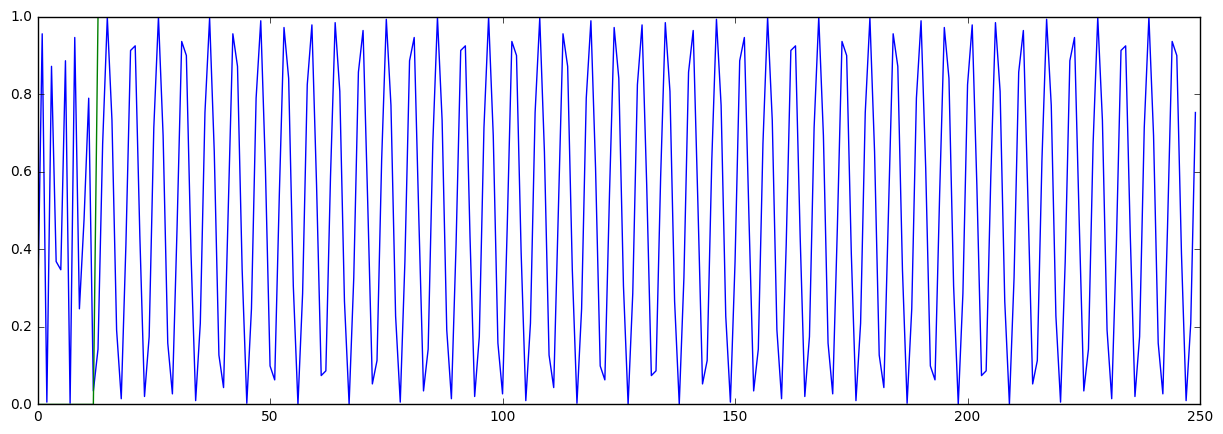

In [70]:
x, y = next(data_generator())
plot(x[:,0])
plot(y[:,0])

In [71]:
def batch(iterator, batch_size):
    while True:
        X = []
        Y = []
        for _ in range(batch_size):
            x, y = next(iterator)
            X.append(x)
            Y.append(y)
        yield np.array(X), np.array(Y)

In [72]:
from tensorflow_hmm.hmm_layer import HMMLayer

In [73]:
# Create your first MLP in Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, InputLayer, Activation

data = batch(data_generator(), BATCH_SIZE)

In [33]:
def make_model(encoder, decoder, loss):
    # create model
    model = Sequential()
    model.add(InputLayer(input_shape=(LENGTH,2)))

    if encoder == 'conv':
        model.add(Conv1D(8, 5, activation='elu', padding='same', strides=1))
        model.add(Conv1D(8, 5, activation='elu', padding='same', strides=1))
    elif encoder == 'lstm':
        model.add(LSTM(8, return_sequences=True))
        model.add(LSTM(2, return_sequences=True))

    if decoder == 'conv':
        model.add(Conv1D(2, 1, activation='elu', padding='same', strides=1))
    elif decoder == 'lstm':
        model.add(LSTM(2, return_sequences=True))

    if loss == 'hmm':
        model.add(HMMLayer(states=2, length=LENGTH))
        model.compile(loss='categorical_crossentropy', optimizer='adam')
    elif loss == 'softmax':
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

In [117]:
model = make_model(encoder='conv', decoder='conv', loss='hmm')

# Fit the model
model.fit_generator(data, epochs=5, steps_per_epoch=16)

Epoch 1/5
16/16 [==============================] - 44s - loss: 0.8444      

viterbi error: 0.4%


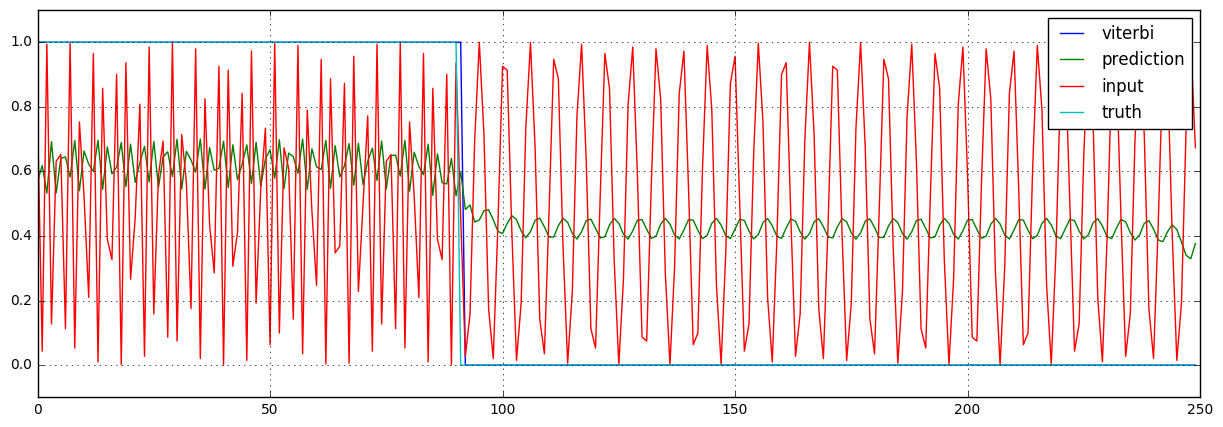

In [133]:
from tensorflow_hmm import hmm

X, Y = data.next()
prediction = model.predict(X)

# TODO: change keras layer to use viterbi during inference
hmm_np = hmm.HMMNumpy(np.array([[0.9, 0.1], [0.1, 0.9]]), p0=np.array([0.5, 0.5]))
viterbi, _ = hmm_np.viterbi_decode(prediction[0,:,:])

print 'viterbi error: {}%'.format(100 * sum((Y[0,:,1] - viterbi)**2) / Y.shape[1])
plot(viterbi, label='viterbi')
plot(prediction[0,:,1], label='prediction')
plot(X[0,:,1], label='input')
plot(Y[0,:,1], label='truth')
ylim(-0.1, 1.1)
grid()
legend()
show()